In [1]:
import pandas as pd
import seaborn as sns

In [2]:
train_identity = pd.read_csv("C:\\Users\\1dare\\Documents\\JupyterNotebook\\telkomsel\\ieee-fraud-detection\\train_identity.csv")
train_transaction = pd.read_csv("C:\\Users\\1dare\\Documents\\JupyterNotebook\\telkomsel\\ieee-fraud-detection\\train_transaction.csv")

In [64]:
test_identity = pd.read_csv("C:\\Users\\1dare\\Documents\\JupyterNotebook\\telkomsel\\ieee-fraud-detection\\test_identity.csv")
test_transaction = pd.read_csv("C:\\Users\\1dare\\Documents\\JupyterNotebook\\telkomsel\\ieee-fraud-detection\\test_transaction.csv")

In [66]:
test_transaction = test_transaction.merge(test_identity, how='left', on='TransactionID')

In [67]:
test_transaction.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
train_transaction.groupby('isFraud').agg(
    cnt=('TransactionID', 'count'),
    amt_mean=('TransactionAmt', 'mean'),
    amt_min=('TransactionAmt', 'min'),
    amt_max=('TransactionAmt', 'max'),
    n_productCD=('ProductCD', lambda x: len(set(x))),
)

,cnt,amt_mean,amt_min,amt_max,n_productCD
isFraud,,,,,
0,569877,134.511665,0.251,31937.391,5
1,20663,149.244779,0.292,5191.000,5


In [20]:
train_transaction = train_transaction.merge(train_identity, how='left', on='TransactionID')

In [21]:
import pandas as pd
from scipy.stats import ks_2samp, chi2_contingency

def compare_distributions(series1: pd.Series, series2: pd.Series, test_type: str = "ks") -> dict:
    """
    Compare the distributions of two pandas Series.

    Parameters:
        series1 (pd.Series): First pandas Series.
        series2 (pd.Series): Second pandas Series.
        test_type (str): Statistical test to use. Options are:
            - "ks" (Kolmogorov-Smirnov test, for continuous data)
            - "chi2" (Chi-square test, for categorical data)

    Returns:
        dict: A dictionary with the test results including:
              - test statistic
              - p-value
              - whether distributions are significantly different.
    """
    if test_type == "ks":
        # Kolmogorov-Smirnov test for continuous data
        statistic, p_value = ks_2samp(series1, series2)
    elif test_type == "chi2":
        # Chi-square test for categorical data
        min_length = min(len(series1), len(series2))
        series1 = series1.iloc[:min_length]
        series2 = series2.iloc[:min_length]
        contingency_table = pd.crosstab(series1, series2)
        statistic, p_value, _, _ = chi2_contingency(contingency_table)
    else:
        raise ValueError("Invalid test_type. Use 'ks' for Kolmogorov-Smirnov or 'chi2' for Chi-square.")

    # Significance level (alpha) is 0.05 by default
    alpha = 0.05
    different = p_value < alpha

    return {
        "test_statistic": statistic,
        "p_value": p_value,
        "distributions_are_different": different
    }

In [22]:
from tqdm import tqdm

result = []
for col in tqdm(train_transaction.dtypes.astype(str).to_frame('type').query("type == 'float64'").index):
    a = train_transaction.query("isFraud == 0")[col].dropna()
    b = train_transaction.query("isFraud == 1")[col].dropna()
    upper = a.quantile(0.95)
    a = a[a <= upper]
    res = compare_distributions(
        a,
        b,
        'ks'
    )
    res['feature'] = col
    result.append(res)

100%|██████████| 399/399 [04:30<00:00,  1.48it/s]


In [23]:
selected_feature = pd.DataFrame(result).query("distributions_are_different == True").sort_values('test_statistic').query("p_value < 0.01")
print(len(selected_feature.feature.tolist()))

373


In [24]:
selected_feature

,test_statistic,p_value,distributions_are_different,feature
61,0.014068,3.218958e-03,True,V25
259,0.018825,2.546240e-03,True,V223
5,0.020908,3.230111e-05,True,addr2
62,0.031056,4.995013e-14,True,V26
322,0.033057,2.410243e-19,True,V286
...,...,...,...,...
300,0.452074,0.000000e+00,True,V264
255,0.453205,0.000000e+00,True,V219
310,0.457020,0.000000e+00,True,V274
301,0.457731,0.000000e+00,True,V265


In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_distributions(series1: pd.Series, series2: pd.Series, labels: tuple = ("Series 1", "Series 2")):
    """
    Visualize the distributions of two numerical pandas Series using Seaborn.

    Parameters:
        series1 (pd.Series): First numerical pandas Series.
        series2 (pd.Series): Second numerical pandas Series.
        labels (tuple): Tuple containing labels for the two Series (default: ("Series 1", "Series 2")).

    Returns:
        None
    """
    # Combine the series into a DataFrame for easier plotting
    data = pd.DataFrame({
        labels[0]: series1,
        labels[1]: series2
    })

    # Plot the distributions
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data[labels[0]], label=labels[0], fill=True, alpha=0.5, color="blue")
    sns.kdeplot(data[labels[1]], label=labels[1], fill=True, alpha=0.5, color="orange")
    plt.title("Comparison of Distributions", fontsize=16)
    plt.xlabel("Value", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.legend(title="Series", fontsize=10)
    plt.grid(visible=True, linestyle='--', alpha=0.6)
    plt.show()

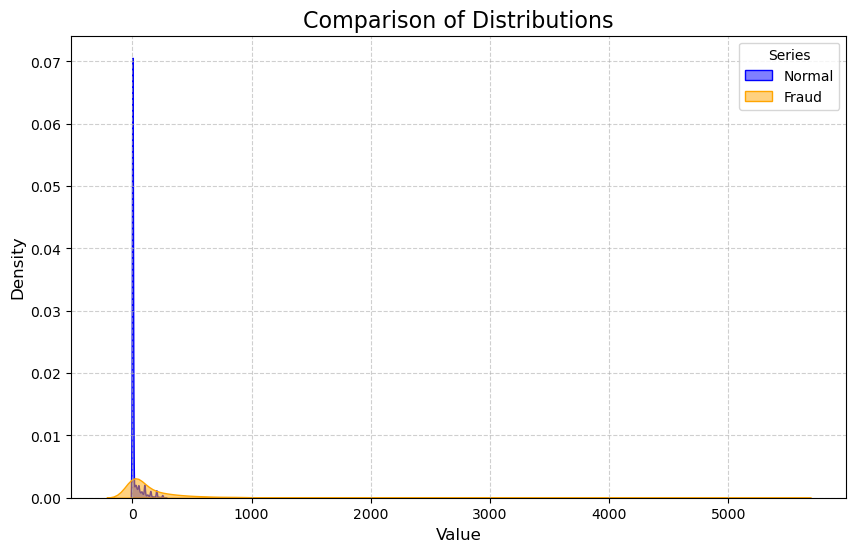

In [26]:
column_name = 'V265'
a = train_transaction.query("isFraud == 0")[column_name].dropna()
upper = a.quantile(0.95)
a = a[a <= upper]
visualize_distributions(
    a, 
    train_transaction.query("isFraud == 1")[column_name].dropna(), 
    labels=("Normal", "Fraud")
)

In [27]:
train_transaction.dtypes.to_frame('type').query("type != 'float64'").index

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=434)

In [28]:
result_cat = []
for col in tqdm(train_transaction.dtypes.astype(str).to_frame('type').query("type == 'object'").index):
    subset = train_transaction[["isFraud", col]].copy()
    subset = subset.dropna()
    a = subset["isFraud"]
    b = subset[col]
    try:
        res = compare_distributions(
            a,
            b,
            'chi2'
        )
    except ValueError:
        continue
    res['feature'] = col
    result_cat.append(res)

100%|██████████| 31/31 [00:01<00:00, 24.00it/s]


In [29]:
selected_cat_feature = pd.DataFrame(result_cat).sort_values('test_statistic').query("distributions_are_different == True")
selected_cat_feature

,test_statistic,p_value,distributions_are_different,feature
11,11.256096,7.936196e-04,True,M7
17,55.145173,1.060176e-12,True,id_23
12,88.530215,5.006429e-21,True,M8
27,95.847507,1.240822e-22,True,id_37
14,119.092679,9.994885e-28,True,id_12
24,187.327111,2.306615e-40,True,id_34
26,194.553071,3.225181e-44,True,id_36
10,227.964137,1.657062e-51,True,M6
9,242.421692,1.165949e-54,True,M5
13,250.372504,2.153926e-56,True,M9


In [32]:
all_features = selected_cat_feature.feature.tolist() + selected_feature.feature.tolist()

In [33]:
len(all_features)

402

In [37]:
train_df_fraud = train_transaction.query("isFraud == 1")
train_df_not_fraud = train_transaction.query("isFraud == 0")

In [43]:
perc_null = (train_df_fraud[all_features].isna().sum() / train_df_fraud.shape[0]).to_frame('perc')
less_null_features = perc_null.index.tolist()
perc_null.query("perc <= 0.15") # 15%

,perc
card4,0.001984
P_emaildomain,0.135024
card6,0.001887
ProductCD,0.000000
V286,0.000097
...,...
C12,0.000000
V303,0.000097
C10,0.000000
C8,0.000000


In [62]:
loc_index = train_transaction[less_null_features].isna().sum(axis=1).to_frame('count_null').query("count_null < 200").index

In [80]:
clean_df = train_transaction[less_null_features].loc[loc_index].copy()

In [76]:
clean_df.dtypes.astype(str).to_frame("type").query("type != 'object'").type.unique()

array(['float64'], dtype=object)

In [82]:
import lightgbm as lgb

In [ ]:
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Sample data
# X: features, y: target
X = clean_df # Your feature data here
y = train_transaction.loc[clean_df.index]["isFraud"]    # Your target variable here

# Define categorical and numerical feature columns
categorical_features = clean_df.dtypes.astype(str).to_frame("type").query("type == 'object'").index
for col in categorical_features:
    clean_df[col] = clean_df[col].astype(str)
numerical_features = clean_df.dtypes.astype(str).to_frame("type").query("type != 'object'").index

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
            ('scaler', StandardScaler())  # Normalize numerical features
        ]), numerical_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing values
            ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Encode categorical features
        ]), categorical_features)
    ])

# Define the full pipeline with the classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', lgb.LGBMClassifier(n_estimators=100, random_state=42))
])

# KFold cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation loop
for train_index, test_index in kf.split(X):
    print("Train")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')    
    f1 = f1_score(y_test, y_pred, average='binary')            

    # Print metrics for each fold
    print(f"Fold accuracy: {accuracy:.4f}")
    print(f"Fold precision: {precision:.4f}")
    print(f"Fold recall: {recall:.4f}")
    print(f"Fold F1 score: {f1:.4f}")
    print("-" * 50)


Train
[LightGBM] [Info] Number of positive: 10158, number of negative: 135446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 41017
[LightGBM] [Info] Number of data points in the train set: 145604, number of used features: 1044
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069765 -> initscore=-2.590311
[LightGBM] [Info] Start training from score -2.590311
Fold accuracy: 0.9692
Fold precision: 0.9126
Fold recall: 0.6210
Fold F1 score: 0.7391
--------------------------------------------------
Train
[LightGBM] [Info] Number of positive: 10186, number of negative: 135419
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_w

In [86]:
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Sample data
# X: features, y: target
X = clean_df # Your feature data here
y = train_transaction.loc[clean_df.index]["isFraud"]    # Your target variable here

# Define categorical and numerical feature columns
categorical_features = clean_df.dtypes.astype(str).to_frame("type").query("type == 'object'").index
for col in categorical_features:
    clean_df[col] = clean_df[col].astype(str)
numerical_features = clean_df.dtypes.astype(str).to_frame("type").query("type != 'object'").index

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
            ('scaler', StandardScaler())  # Normalize numerical features
        ]), numerical_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing values
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Encode categorical features
        ]), categorical_features)
    ])

# Define the full pipeline with the classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])

# KFold cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation loop
for train_index, test_index in kf.split(X):
    print("Train")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')    
    f1 = f1_score(y_test, y_pred, average='binary')            

    # Print metrics for each fold
    print(f"Fold accuracy: {accuracy:.4f}")
    print(f"Fold precision: {precision:.4f}")
    print(f"Fold recall: {recall:.4f}")
    print(f"Fold F1 score: {f1:.4f}")
    print("-" * 50)


Train
Fold accuracy: 0.1671
Fold precision: 0.0773
Fold recall: 0.9922
Fold F1 score: 0.1434
--------------------------------------------------
Train
Fold accuracy: 0.1717
Fold precision: 0.0765
Fold recall: 0.9870
Fold F1 score: 0.1421
--------------------------------------------------
Train
Fold accuracy: 0.1692
Fold precision: 0.0784
Fold recall: 0.9888
Fold F1 score: 0.1453
--------------------------------------------------
Train
Fold accuracy: 0.1656
Fold precision: 0.0762
Fold recall: 0.9933
Fold F1 score: 0.1415
--------------------------------------------------
Train
Fold accuracy: 0.1624
Fold precision: 0.0755
Fold recall: 0.9920
Fold F1 score: 0.1404
--------------------------------------------------


,type
V25,float64
V223,float64
addr2,float64
V26,float64
V286,float64
...,...
V264,float64
V219,float64
V274,float64
V265,float64


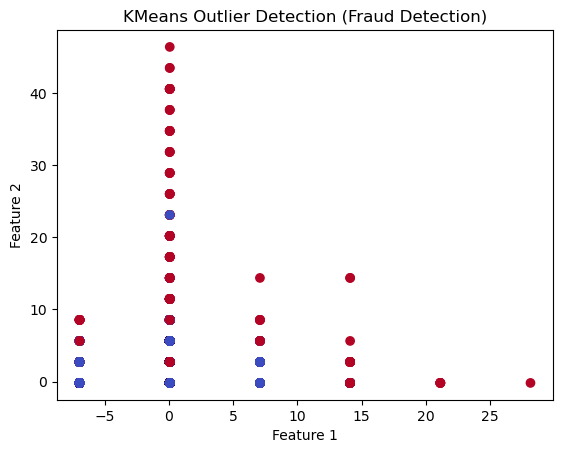

Outliers (Fraudulent data points) indices: [    79     94     96 ... 181995 181996 182000]


In [92]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Sample data (replace this with your actual dataset)
# X = pd.DataFrame(...) # Your feature data here
# For demonstration, generating random data
cols = clean_df.dtypes.astype(str).to_frame('type').query("type == 'float64'").index
X = clean_df[cols]  # 100 samples, 2 features
imputer = SimpleImputer(strategy='median')  # You can choose other strategies like 'median' or 'most_frequent'
X = imputer.fit_transform(X)
# Step 1: Normalize the data (important for KMeans)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Assume 3 clusters (adjust based on your data)
kmeans.fit(X_scaled)

# Step 3: Calculate distance from each point to its cluster center
distances = kmeans.transform(X_scaled)
min_distances = np.min(distances, axis=1)  # Minimum distance to the closest cluster center

# Step 4: Define a threshold for outliers based on the distances
threshold = np.percentile(min_distances, 95)  # Outliers are points further than the 95th percentile

# Step 5: Flag outliers (fraudulent transactions) based on the threshold
outliers = min_distances > threshold

# Step 6: Visualize the data and the outliers
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=outliers, cmap='coolwarm', marker='o')
plt.title("KMeans Outlier Detection (Fraud Detection)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# Step 7: Output the indices of the outliers (fraudulent data points)
outlier_indices = np.where(outliers)[0]
print("Outliers (Fraudulent data points) indices:", outlier_indices)